In [1]:
# basic
import numpy as np
import pandas as pd

# gnn and train
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import gat_v2, graph_sage

# demo
import matplotlib.pyplot as plt

2022-12-15 05:40:14.015142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 05:40:14.171349: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 05:40:14.176525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 05:40:14.176548: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [8]:
train_fp = './tfgnn_dataset/nexmark_isBP_train.tfrecord'
val_fp = './tfgnn_dataset/nexmark_isBP_val.tfrecord'
test_fp = './tfgnn_dataset/nexmark_isBP_test.tfrecord'
schema_fp = './tfgnn_dataset/schema_poc.pbtxt'

In [10]:
# Read the dataset of tf.Example protos for training.
train_ds = tf.data.TFRecordDataset(filenames=[train_fp]).prefetch(10000)
val_ds = tf.data.TFRecordDataset(filenames=[val_fp])
test_ds = tf.data.TFRecordDataset(filenames=[test_fp])
# Parse the GraphTensor values.
graph_schema = tfgnn.read_schema(schema_fp)

In [11]:
# def decode_fn(record_bytes, graph_schema):
#     graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)
#     graph = tfgnn.parse_single_example(graph_tensor_spec, record_bytes, validate=True)

#     # extract label from context and remove from input graph
#     context_features = graph.context.get_features_dict()
#     label = context_features.pop('label_isBP')
#     new_graph = graph.replace_features(context=context_features)
#     return new_graph, label

In [14]:
train_ds = train_ds.batch(5)

In [20]:
example_input_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)
train_ds = train_ds.map(tfgnn.keras.layers.ParseExample(example_input_spec))

TypeError: parse_single_example() missing 1 required positional argument: 'serialized'

In [19]:
train_ds = train_ds.repeat()

In [4]:
dataset.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


GraphTensorSpec({'context': ContextSpec({'features': {'label_isBP': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'bytes_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), 'records_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'operate': NodeSetSpec({'features': {'bytes_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'records_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'utilization_embedding': RaggedTensorSpec(TensorShape([None, None, 6]), tf.float32, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'source': NodeSetSpec({'features': {'parallelism': RaggedTensorSpec(TensorS

In [5]:
# Define pre-process model for initial hidden states, actually all partial models
def node_sets_fn(node_set, *, node_set_name):
    if node_set_name == 'source':
        return node_set['parallelism']
    elif node_set_name == 'operate':
        print(node_set)
#         stacked_non_embed = tf.stack([node_set['bytes_selectivity'], 
#                                       node_set['records_selectivity'], 
#                                       node_set['parallelism']], axis=2)
        stacked_non_embed = tf.keras.layers.Concatenate()([node_set['bytes_selectivity'], 
                                                          node_set['records_selectivity'], 
                                                            node_set['parallelism']])
        print('stacked_non_embed:', stacked_non_embed)
        return tf.keras.layers.Concatenate()([ 
            node_set['utilization_embedding'],
            stacked_non_embed,
            ])

# def edge_sets_fn(): TODO

def context_fn(context):
#     stacked_cont = tf.stack([context['bytes_input_rate'], 
#                     context['records_input_rate'],], axis=2)
    stacked_cont = tf.keras.layers.Concatenate()([context['bytes_input_rate'], 
                                                  context['records_input_rate'],],)
    return {'hidden_state': stacked_cont,
            'label_isBP': context['label_isBP']}

def split_fn(graph):
    labels = tfgnn.keras.layers.Readout(from_context=True,
                                    feature_name="label_isBP")(graph)
    graph = graph.remove_features(context=['label_isBP'])
    assert "label_isBP" not in graph.context.features
    return graph, labels

In [6]:
# Define and apply the preprocessing model. (now starts to define a graph model with the view of a scalar sample)
preproc_input = tf.keras.layers.Input(type_spec=preproc_input_spec)
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                      context_fn=context_fn,
                                      )(preproc_input)  # With preprocessed features, see below.
graph = graph.merge_batch_to_components()  # See section "Merging a batch".

graph, mask = tfgnn.keras.layers.PadToTotalSizes(size_constraints)(graph) # pad
graph, labels = split_fn(graph)  # See section "Splitting the label off ...".

preproc_model = tf.keras.Model(preproc_input, (graph, labels, mask))  # now we defined the pp-model

# above is just a defined computing process, the following is the process process on the whole dataset
dataset = dataset.map(preproc_model)

KerasTensor(type_spec=NodeSetSpec({'features': {'bytes_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'records_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'utilization_embedding': RaggedTensorSpec(TensorShape([None, None, 6]), tf.float32, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), description="created by layer 'input_3'")
stacked_non_embed: KerasTensor(type_spec=RaggedTensorSpec(TensorShape([None, None, 3]), tf.float32, 1, tf.int32), description="created by layer 'concatenate_1'")


In [7]:
### testing
DATASET_SIZE = 5460
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

dataset = train_dataset
### end testing

In [8]:
# assert list(graph.node_sets["operate"].keys()) == [tfgnn.HIDDEN_STATE]
# BUG: not working, use manual checking:
list(graph.node_sets['operate'].get_features_dict().keys()),list(graph.node_sets['source'].get_features_dict().keys())

(['hidden_state'], ['hidden_state'])

In [9]:
# define gnn update logic (using gatv2)
def gnn(graph):
    for i in range(2):
        graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=5, num_heads=1, receiver_tag=tfgnn.TARGET)(graph)
#         graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=5, num_heads=1, receiver_tag=tfgnn.SOURCE,)(graph)
    return graph

In [10]:
model_input_spec, _, __ = dataset.element_spec
model_input_spec

GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(11, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(27, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(11, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'op2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(16,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(16,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'operate', '#index.1': 'operate'})}, Tens

In [11]:
# Define and train the main model.
model_input_spec, _, __ = dataset.element_spec  # Drop the spec for the labels.
model_input = tf.keras.layers.Input(type_spec=model_input_spec)
graph = gnn(model_input) # apply gnn model

# Classifying each graph as a whole, based on an aggregation of the node states from one node set
pooled_features_s = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="source")(graph)
pooled_features_op = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="operate")(graph)

pooled_features = tf.keras.layers.concatenate([pooled_features_s, pooled_features_op])

# logits = tf.keras.layers.Dense(1)(pooled_features_op) # output
logits = tf.keras.layers.Dense(1)(pooled_features) # output

model = tf.keras.Model(model_input, logits)

# compile this model for binary classification
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_filecjtikw8n.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_filecjtikw8n.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [()]                 0           []      

In [12]:
# train
history = model.fit( dataset,
                     steps_per_epoch=10,
                     epochs=200,)

Epoch 1/200
10/10 [==============================] - 4s 7ms/step - loss: 1.7392
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.6617
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 1.4640
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 1.4764
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 1.3316
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 1.0416
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.8865
Epoch 8/200
10/10 [==============================] - 0s 6ms/step - loss: 0.8689
Epoch 9/200
10/10 [==============================] - 0s 6ms/step - loss: 0.8725
Epoch 10/200
10/10 [==============================] - 0s 6ms/step - loss: 0.7396
Epoch 11/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7690
Epoch 12/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7376
Epoch 13/200
10/10 [=================

InvalidArgumentError: Graph execution error:

assertion failed: [Could not pad <op2op> as it already has more edges then it is allowed by the `total_sizes.total_num_edges[<op2op>]`.] [Condition x == y did not hold element-wise:] [x (model/pad_to_total_sizes/LessEqual_5:0) = ] [0] [y (model/pad_to_total_sizes/assert_equal_15/y:0) = ] [1]
	 [[{{node model/pad_to_total_sizes/assert_equal_15/Assert/AssertGuard/Assert}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_9521]

In [ ]:
# Export the combined SavedModel for serving.
# this part can be waived for current situation..
# serving_input = tf.keras.layers.Input(shape=[],  # The batch dim is implied.
#                                       dtype=tf.string, name="examples")
# preproc_input = tfgnn.keras.layers.ParseExample(example_input_spec)(serving_input)
# serving_model_input, _ = preproc_model(preproc_input)  # Drop labels.
# serving_logits = model(serving_model_input)
# serving_output = {"logits": tf.keras.layers.Layer(name="logits")(serving_logits)}
# exported_model = tf.keras.Model(serving_input, serving_output)
# exported_model.save("/tmp/exported_keras_model", include_optimizer=False)

In [27]:
tf.stack([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

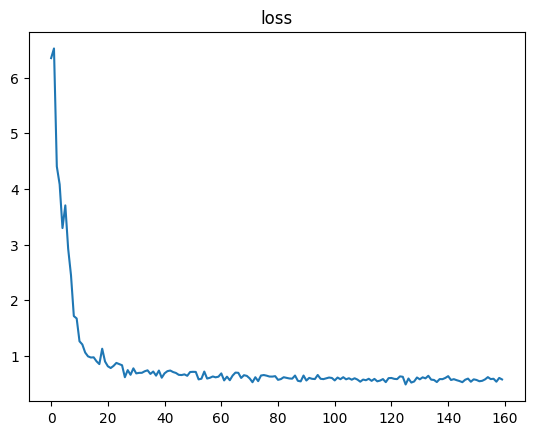

In [82]:
for k, hist in history.history.items():
    plt.plot(hist)
    plt.title(k)
    plt.show()

In [89]:
test_dataset

<TakeDataset element_spec=(GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(11, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(11, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(27, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'op2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(16,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(16,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'operate', '#i